# 03 - Base Model and Custom Metrics

In [92]:
import os, gc, warnings
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_fscore_support
from lightgbm import early_stopping, log_evaluation
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42

# plt.rcParams['figure.figsize'] = [12, 5]
plt.rcParams['figure.dpi'] = 100


warnings.filterwarnings('ignore')

## Preparing the Data

In [93]:
DATA_PATH = '../data/processed/'     

In [94]:
df = pd.read_csv(os.path.join(DATA_PATH, 'transactions_processed.csv'))

In [95]:
test_mask  = (df['year']==2020) & (df['trans_month']==12) 
valid_mask = (df['year']==2020) & (df['trans_month'].between(10,11))
train_mask = ~test_mask & ~valid_mask

train_df, valid_df, test_df = df[train_mask], df[valid_mask], df[test_mask]

## Preprocessing

In [96]:
target = 'is_fraud'
ignore = [target,'transaction_datetime']

features = [c for c in df.columns if c not in ignore]
cat_cols = [c for c in features if df[c].dtype=='object']

#  LightGBM requires categorical features instead of object dtype.
for c in cat_cols:
    for part in (train_df, valid_df, test_df):
        part[c] = part[c].astype('category')

## Base Model

### Utility Functions

In [97]:
def kpi_report(model, df, thr):
    predictions = model.predict(df[features])
    actuals = df[target].values
    is_frequent = df["is_frequent_merchant"].values
    predicted_fraud = predictions >= thr

    tp = ((actuals == 1) & predicted_fraud).sum()
    fn = ((actuals == 1) & ~predicted_fraud).sum()
    fp = ((actuals == 0) & predicted_fraud).sum()

    fp_freq = ((actuals == 0) & predicted_fraud & (is_frequent == 1)).sum()
    legitimate_freq = ((actuals == 0) & (is_frequent == 1)).sum()

    recall = tp / (tp + fn)
    fpr = fp / (actuals == 0).sum()
    fpr_freq = fp_freq / legitimate_freq

    fp_tp_ratio_overall = (tp + fp) / tp
    fp_tp_ratio_freq = (tp + fp_freq) / tp

    results = {
        "recall": recall,
        "fpr": fpr,
        "fpr_freq": fpr_freq,
        "fp_tp_ratio_overall": fp_tp_ratio_overall,
        "fp_tp_ratio_freq": fp_tp_ratio_freq
    }
    
    return results

def detailed_evaluation_report(
    model,
    df,
    features,
    target,
    thr=0.5,
    return_dict=False
):
    """
    Prints overall & frequent-customer FP rates,
    classification report, and two heatmaps.
    Returns a dict of metrics if return_dict=True.
    """
    # 1) Predictions
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(df[features])[:, 1]
    else:
        probs = model.predict(df[features])
    preds = (probs >= thr).astype(int)
    y_true = df[target].values
    is_freq = df["is_frequent_merchant"].values.astype(bool)

    # 2) Classification report
    print("=== Classification Report ===")
    print(classification_report(y_true, preds, digits=4))

    # 3) Confusion matrix & overall FP rate
    tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()
    overall_fp_rate = fp / (tn + fp) if (tn + fp) else 0
    print(f"\nOverall false positives : {fp}")
    print(f"Overall FP rate         : {overall_fp_rate*100:.4f}%")

    # 4) Frequent-customer FP rate
    legit_freq_mask = (~y_true.astype(bool)) & is_freq
    freq_count = legit_freq_mask.sum()
    fp_freq = (preds.astype(bool) & legit_freq_mask).sum()
    if freq_count:
        freq_fp_rate = fp_freq / freq_count
        print("\n=== Frequent-Customer FP ===")
        print(f"False positives (freq)  : {fp_freq}")
        print(f"FP rate (freq)          : {freq_fp_rate*100:.4f}%")
    else:
        freq_fp_rate = 0
        print("\nNo frequent-customer legits to evaluate.")

    # 5) Plots
    fig, axes = plt.subplots(1, 1, figsize=(6, 4))
    cm_all = confusion_matrix(y_true, preds)
    sns.heatmap(cm_all, annot=True, fmt="d", ax=axes, cmap="Blues")
    axes.set(title="Confusion Matrix", xlabel="Predicted", ylabel="Actual")

    plt.tight_layout()
    plt.show()

    # 6) Return dict if wanted
    results = {
        "overall_fp_rate": overall_fp_rate,
        "overall_fp_count": fp,
        "freq_fp_rate": freq_fp_rate,
        "freq_fp_count": fp_freq,
        "freq_legit_count": freq_count,
        "tn": tn, "fp": fp, "fn": fn, "tp": tp,
    }
    if return_dict:
        return results


### Training

In [98]:
params = dict(
    objective="binary",
    learning_rate=0.05,
    num_leaves=64,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=5,
    seed=42,
    verbosity=-1,
    max_depth=10,
    min_child_samples=50,
    scale_pos_weight=50,
    min_child_weight=0.1,
)


model = lgb.LGBMClassifier(
    **params,
    n_estimators=500,
    metric="auc"
)

model.fit(
    X=train_df[features],
    y=train_df[target],
    sample_weight=None,
    eval_set=[(valid_df[features], valid_df[target])],
    categorical_feature=cat_cols,
    callbacks=[ lgb.early_stopping(50)],
    eval_metric="auc",
)



Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's auc: 0.975881


LGBMClassifier(bagging_fraction=0.8, bagging_freq=5, feature_fraction=0.8,
               learning_rate=0.05, max_depth=10, metric='auc',
               min_child_samples=50, min_child_weight=0.1, n_estimators=500,
               num_leaves=64, objective='binary', scale_pos_weight=50, seed=42,
               verbosity=-1)

#### Results

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9996    0.9935    0.9965    139280
           1     0.1807    0.7713    0.2929       258

    accuracy                         0.9931    139538
   macro avg     0.5902    0.8824    0.6447    139538
weighted avg     0.9981    0.9931    0.9952    139538


Overall false positives : 902
Overall FP rate         : 0.6476%

=== Frequent-Customer FP ===
False positives (freq)  : 63
FP rate (freq)          : 0.3399%


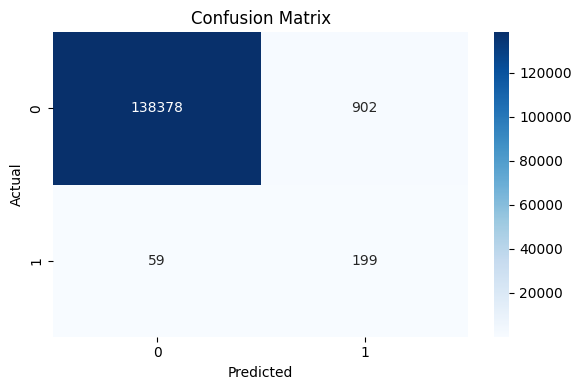

In [99]:
detailed_evaluation_report(model, test_df, features, target, 0.9)

## Custom Metrics

In [100]:
def make_weights(part, legit_freq_w=10.0):
    """Boost loss on legitimate frequent‑customer rows."""
    w = np.ones(len(part))
    mask = (part['is_frequent_merchant'] == 1) & (part[target] == 0)
    w[mask] = legit_freq_w         
    return w

w_train = make_weights(train_df, 7.5)
w_valid = make_weights(valid_df, 7.5)

In [101]:
lgb_train = lgb.Dataset(
    train_df[features],
    label=train_df[target],
    weight=w_train,
    categorical_feature=cat_cols,
    free_raw_data=False,
)
lgb_valid = lgb.Dataset(
    valid_df[features],
    label=valid_df[target],
    weight=w_valid,
    categorical_feature=cat_cols,
    free_raw_data=False,
    reference=lgb_train,
)

In [102]:
freq_map = {
    id(lgb_train): train_df["is_frequent_merchant"].values,
    id(lgb_valid): valid_df["is_frequent_merchant"].values,
}

In [103]:
def fp_tp_ratio(preds, data):
    """
    Custom metric: (TP + FP) / TP
    Lower is better. Measures overall alert burden relative to true positives
    """
    y_true  = data.get_label()
    y_pred  = preds > 0.50            # fixed cut-off inside metric
    tp      = ((y_true==1) & y_pred).sum()
    fp      = ((y_true==0) & y_pred).sum()
    ratio   = (tp + fp) / tp if tp else np.inf
    return 'fp_tp_ratio', ratio, False


def balanced_cost(preds, data, w_fp=3.0, w_fn=10.0):
    """
    Custom cost: w_fp * FP_on_frequent + w_fn * FN
    Lower is better. Balances penalties for missing fraud vs. false alerts on frequent customers
    """
    y_true = data.get_label()
    freq   = freq_map[id(data)]
    y_pred = preds > 0.50

    fp_freq = ((y_true==0) & y_pred & (freq==1)).sum()
    fn      = ((y_true==1) & ~y_pred).sum()
    cost    = w_fp * fp_freq + w_fn * fn
    return 'balanced_cost', cost, False


def f05_score(preds, data):
    """
    Custom F-beta score (beta=0.5), negated for maximization.
    Higher is better. Emphasizes precision (FP control) twice as much as recall.
    """
    y_true = data.get_label()
    y_pred = preds > 0.50
    tp = ((y_true==1) & y_pred).sum()
    fp = ((y_true==0) & y_pred).sum()
    fn = ((y_true==1) & ~y_pred).sum()

    precision = tp / (tp + fp) if (tp + fp) else 0
    recall    = tp / (tp + fn) if (tp + fn) else 0
    beta2 = 0.25         # beta^2 = (0.5)^2
    score = (1 + beta2) * precision * recall / (beta2 * precision + recall) if (precision+recall) else 0
    return 'f05_score', -score, True  # negative because LGBM expects lower-is-worse True


def freq_fpr(preds, data):
    """
    Frequent-customer false-positive rate: FP_freq / Legit_freq
    Lower is better. Measures share of frequent customers erroneously flagged
    """
    y_true = data.get_label()
    freq   = freq_map[id(data)]
    y_pred = preds > 0.50

    fp_freq   = ((y_true==0) & y_pred & (freq==1)).sum()
    legit_freq = ((y_true==0) & (freq==1)).sum()
    fpr = fp_freq / legit_freq if legit_freq else 0
    return 'freq_fpr', fpr, False

In [104]:
metrics = [fp_tp_ratio, balanced_cost, f05_score, freq_fpr]


def run_and_log(feval_fn, legit_freq_w=10.0):
    w_train = make_weights(train_df, legit_freq_w)
    w_valid = make_weights(valid_df, legit_freq_w)
    lgb_train.set_weight(w_train)
    lgb_valid.set_weight(w_valid)

    print(f"\n -> {feval_fn.__name__}")

    params = dict(
        objective="binary",
        learning_rate=0.05,
        num_leaves=64,
        feature_fraction=0.8,
        bagging_fraction=0.8,
        bagging_freq=5,
        seed=42,
        verbosity=-1,
        scale_pos_weight=50,
        min_child_weight=0.1,
    )

    mdl = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_valid],
        valid_names=["valid"],
        feval=feval_fn,
        num_boost_round=500,
        callbacks=[early_stopping(50)],
    )

    best = mdl.best_score["valid"][feval_fn.__name__]
    return mdl, best


results = {}
models = {}
for fe in metrics:
    model, score = run_and_log(fe, legit_freq_w=10)  
    results[fe.__name__] = score
    models[fe.__name__] = model


 -> fp_tp_ratio
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[319]	valid's binary_logloss: 0.00590922	valid's fp_tp_ratio: 1.15546

 -> balanced_cost
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	valid's binary_logloss: 0.0166253	valid's balanced_cost: 1088

 -> f05_score
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid's binary_logloss: 0.0435814	valid's f05_score: -0.298777

 -> freq_fpr
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[162]	valid's binary_logloss: 0.00663957	valid's freq_fpr: 0.000471984



Model: fp_tp_ratio
=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9991    0.9998    0.9995    139280
           1     0.8214    0.5349    0.6479       258

    accuracy                         0.9989    139538
   macro avg     0.9103    0.7673    0.8237    139538
weighted avg     0.9988    0.9989    0.9988    139538


Overall false positives : 30
Overall FP rate         : 0.0215%

=== Frequent-Customer FP ===
False positives (freq)  : 0
FP rate (freq)          : 0.0000%


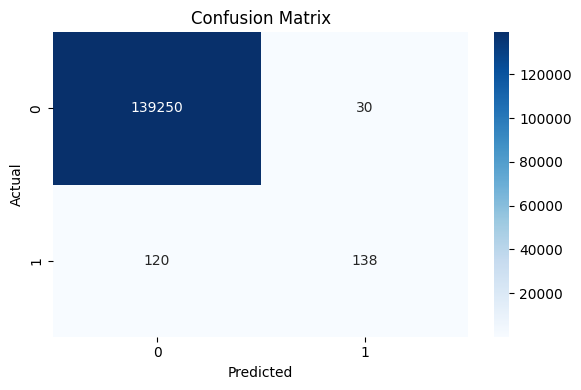


Model: balanced_cost
=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9995    0.9972    0.9983    139280
           1     0.3236    0.7287    0.4482       258

    accuracy                         0.9967    139538
   macro avg     0.6615    0.8629    0.7232    139538
weighted avg     0.9982    0.9967    0.9973    139538


Overall false positives : 393
Overall FP rate         : 0.2822%

=== Frequent-Customer FP ===
False positives (freq)  : 29
FP rate (freq)          : 0.1565%


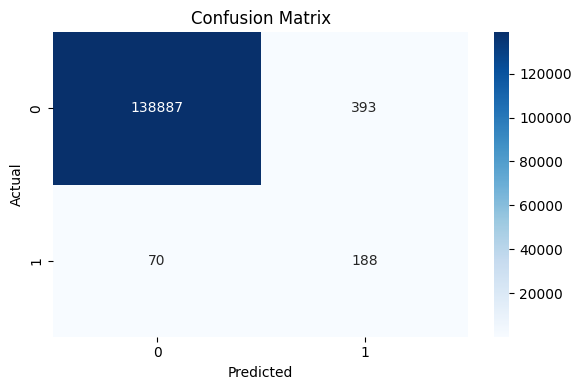


Model: f05_score
=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9996    0.9894    0.9945    139280
           1     0.1196    0.7752    0.2073       258

    accuracy                         0.9890    139538
   macro avg     0.5596    0.8823    0.6009    139538
weighted avg     0.9980    0.9890    0.9930    139538


Overall false positives : 1472
Overall FP rate         : 1.0569%

=== Frequent-Customer FP ===
False positives (freq)  : 92
FP rate (freq)          : 0.4963%


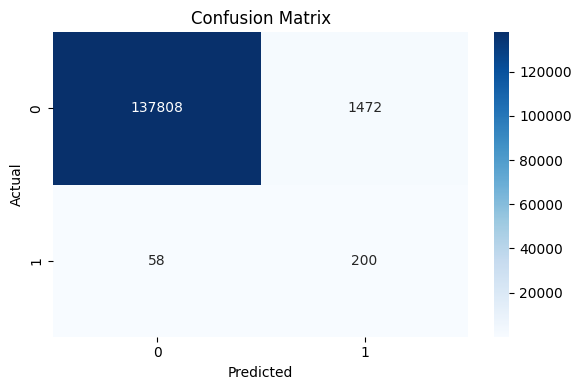


Model: freq_fpr
=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9991    0.9995    0.9993    139280
           1     0.6615    0.4922    0.5644       258

    accuracy                         0.9986    139538
   macro avg     0.8303    0.7459    0.7819    139538
weighted avg     0.9984    0.9986    0.9985    139538


Overall false positives : 65
Overall FP rate         : 0.0467%

=== Frequent-Customer FP ===
False positives (freq)  : 2
FP rate (freq)          : 0.0108%


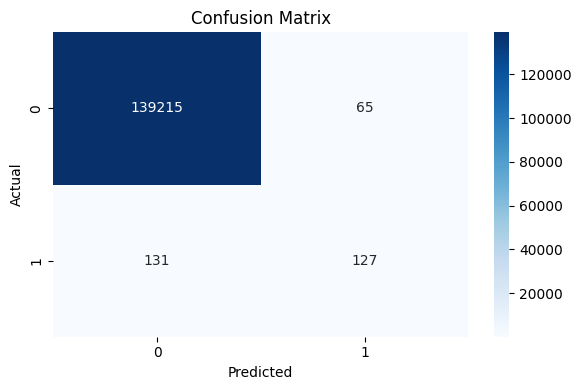

In [105]:
for model_name, model in models.items():
     print(f"\nModel: {model_name}")
     detailed_evaluation_report(model, test_df, features, target, 0.9)